# Self-supervised

This example shows how to train a neural operator on sine functions
in a self-supervised manner.

## Setup

In [1]:
import torch
import matplotlib.pyplot as plt
from continuiti.benchmarks.sine import SineBenchmark
from continuiti.data.selfsupervised import SelfSupervisedOperatorDataset
from continuiti.operators.integralkernel import NaiveIntegralKernel, NeuralNetworkKernel
from continuiti.trainer import Trainer

In [2]:
torch.manual_seed(1)
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)
plt.rcParams["legend.framealpha"] = 0.0

## Dataset

Create a data set of sine waves: The `SineBenchmark` generates $N$ sine waves
$$
f(x) = \sin(w_k x), \quad w_k = 1 + \frac{k}{N-1},
$$
$$
\quad k = 0, \dots, N-1.
$$
We wrap the dataset by a `SelfSupervisedDataset` that exports samples
for self-supervised training, namely
$$
\left(\mathbf{x}, f(\mathbf{x}), x_j, f(x_j)\right), \quad \text{for } j = 1, \dots, M,
$$
where $\mathbf{x} = (x_i)_{i=1 \dots M}$ are the $M$ equidistantly
distributed sensor positions.

In [3]:
benchmark = SineBenchmark(n_sensors=32, n_train=4, n_evaluations=3)
sine = benchmark.train_dataset
dataset = SelfSupervisedOperatorDataset(sine.x, sine.u)

This dataset contains 128 samples. Let's plot a random one!

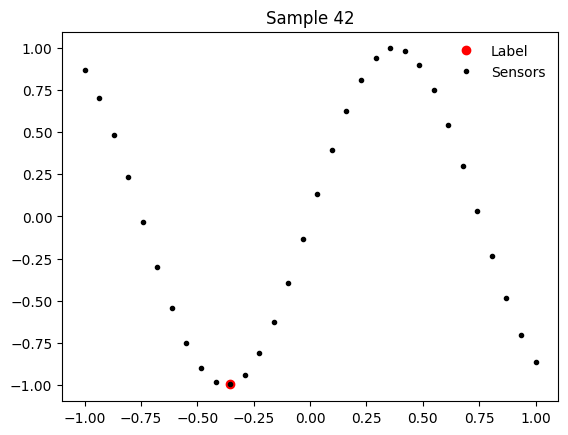

In [4]:
x, u, y, v = dataset[42]
plt.plot(y.flatten(), v.flatten(), 'ro', label='Label')
plt.plot(x.flatten(), u.flatten(), 'k.', label='Sensors')
plt.legend()
plt.title("Sample 42")
plt.show()

## Operator

In this example, we use a `NaiveIntegralKernel` as neural operator with a
`NeuralNetworkKernel` as kernel function.

In [5]:
kernel = NeuralNetworkKernel(dataset.shapes, kernel_width=128, kernel_depth=8)
operator = NaiveIntegralKernel(kernel)

## Training

Train the neural operator.

In [6]:
Trainer(operator).fit(dataset, tol=1e-3, batch_size=128)

Parameters: 116097  Device: mps
Epoch 71/1000  Step 1/1  [====================]  8ms/step  ETA 0:07min - loss/train = 9.9223e-04  - stopping criterion met



## Plotting

Plot model predictions for training data.

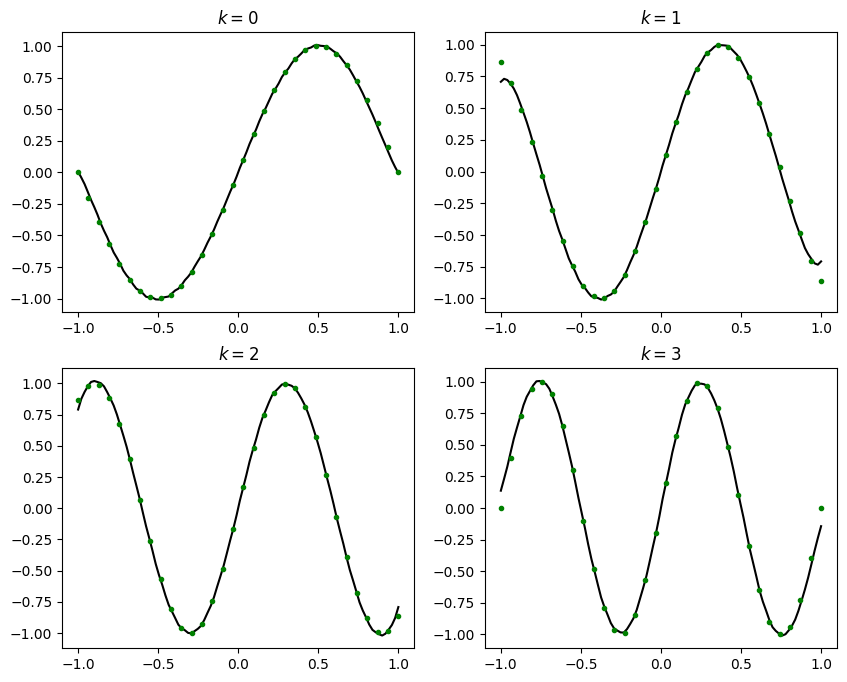

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for i in range(len(sine)):
    ax = axs[i//2][i%2]
    x, u = sine.x[i], sine.u[i]
    y = torch.linspace(-1, 1, 100).reshape(1, -1)
    v = operator(x.unsqueeze(0), u.unsqueeze(0), y.unsqueeze(0)).squeeze(0).detach()
    ax.plot(y.flatten(), v.flatten(), 'k-', label='Prediction')
    ax.plot(x.flatten(), u.flatten(), 'g.', label='Sensors')
    ax.set_title(f"$k = {i}$")

## Generalization

Plot prediction on a test sample which was not part of the training set.

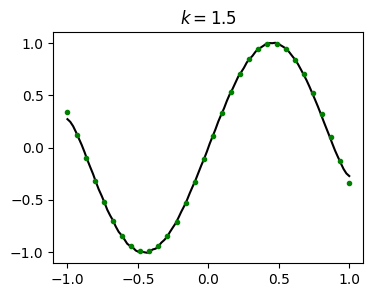

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

x, u = benchmark.test_dataset.x[1], benchmark.test_dataset.u[1]
y = torch.linspace(-1, 1, 100).reshape(1, -1)
v = operator(x.unsqueeze(0), u.unsqueeze(0), y.unsqueeze(0)).squeeze(0).detach()
ax.plot(y.flatten(), v.flatten(), 'k-', label='Prediction')
ax.plot(x.flatten(), u.flatten(), 'g.', label='Sensors')
ax.set_title(f"$k = {1.5}$")
plt.show()